In [1]:
import disentangler as dt
from disentangler.dependencies import *

In [2]:
rna_data = dt.bonemarrow.utils.load_GEX_data()

In [161]:
mira_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_NO_DISENTANGLEMENT+'2')

mira_model.predict(rna_data)
mira_model.get_batch_effect(rna_data)
mira_model.impute(rna_data)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: batch_effect
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed


from tqdm.notebook import tqdm

corrs = {}
for i in tqdm(range(rna_data.n_vars)):
    corrs[rna_data.var_names[i]] = \
        np.corrcoef(rna_data.layers['imputed'][:,i], rna_data.layers['batch_effect'][:,i])[0,1]

rna_data.var = rna_data.var.drop(columns = ['entanglement'])

rna_data.var = rna_data.var.join(pd.Series(corrs, name = 'entanglement'), how = 'left')

rna_data.var[(rna_data.var.dispersions_norm > 0.5) & (rna_data.var.mean_counts > 0.5) & rna_data.var.entanglement > .7]\
    .sort_values('entanglement').tail(50).index.values

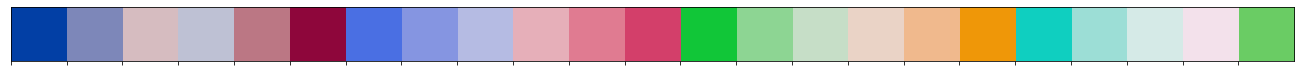

In [162]:
sns.palplot(list(dt.bonemarrow.colors.CELL_PALETTE.values())+[sns.color_palette('muted')[2]])

In [163]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [164]:
bonemarrow = list(dt.bonemarrow.colors.CELL_PALETTE.values())
tab10 = sns.color_palette('tab10')
yuck_colors = [tab10[0], bonemarrow[13], tab10[4], tab10[-1]]

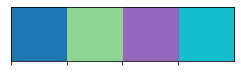

In [165]:
sns.palplot(yuck_colors)

In [166]:
from collections import defaultdict

select_cells = {k:'#EEEEEE' for k in dt.bonemarrow.colors.CELL_PALETTE.keys()}
select_cells.update({k : yuck_colors[i]#dt.bonemarrow.colors.CELL_PALETTE[k]
             for i,k in enumerate(['Erythroblast','CD8+ T','CD16+ Mono','Naive CD20+ B'])
            })

In [167]:
def entanglement_panel(adata, ax, gene, cell_type = None):
    
    alpha = 1.
    dt.plots.disentanglement_plot(adata, 
        ax[0], gene, 
        palette = sns.color_palette('light:black', as_cmap=True), 
        size = 1, 
        alpha = alpha,
        vmin = -0.25)
    
    
    dt.plots.disentanglement_plot(adata, ax[1], gene, 
        color = 'cell_type', 
        palette = list(select_cells.values()), 
        add_legend=False,
        size = 1,
        alpha = 1.,
        hue_order = list(select_cells.keys())
                                 )
    
    if False:
        dt.plots.disentanglement_plot(adata[adata.obs.cell_type==cell_type], ax[1], gene, 
            color = 'cell_type', 
            palette = ['black']*len(select_cells),
            add_legend=False,
            size = 4,
            alpha = 1.,
        )
        
        dt.plots.disentanglement_plot(adata[adata.obs.cell_type==cell_type], ax[1], gene, 
            color = 'cell_type', 
            palette = ['white']*len(select_cells),
            add_legend=False,
            size = 1.5,
            alpha = 1.,
        )
        
        dt.plots.disentanglement_plot(adata[adata.obs.cell_type==cell_type], ax[1], gene, 
            color = 'cell_type', 
            palette = [select_cells[cell_type]]*len(select_cells), 
            add_legend=False,
            size = 1,
            alpha = 1.,
        )
        

    dt.plots.disentanglement_plot(adata, ax[2], gene, 
        color = 'batch', 
        palette = list(dt.bonemarrow.colors.BATCH_PALETTE.values()),
        add_legend=False,
        size = 1,
        alpha = 1.,
        hue_order = list(dt.bonemarrow.colors.BATCH_PALETTE.keys())
                                 )

    for _ax in np.ravel(ax):
        _ax.set(ylabel = '', yticks = [], xticks = [0], xlabel = '')

    ax[0].set_title(gene)
    ax[1].set_title(None)
    ax[2].set_title(None)

    plt.tight_layout()
    
    return ax

In [168]:
# MGAT5,VCAN, KLF4, IGGL1, CCL5, 

fig, ax = plt.subplots(3,1,figsize=(3,9), sharex = True)
entanglement_panel(rna_data, ax, 'ITGA2B')
#plt.savefig('figure1/marginal_panels/entangled_MGAT5.png', bbox_inches = 'tight', dpi = 300)

/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/plots/base.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  palette_obj = lambda i : np.array(palette)[i]
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/plots/base.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array([class_colors[c_class] for c_class in c])
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/plots/base.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

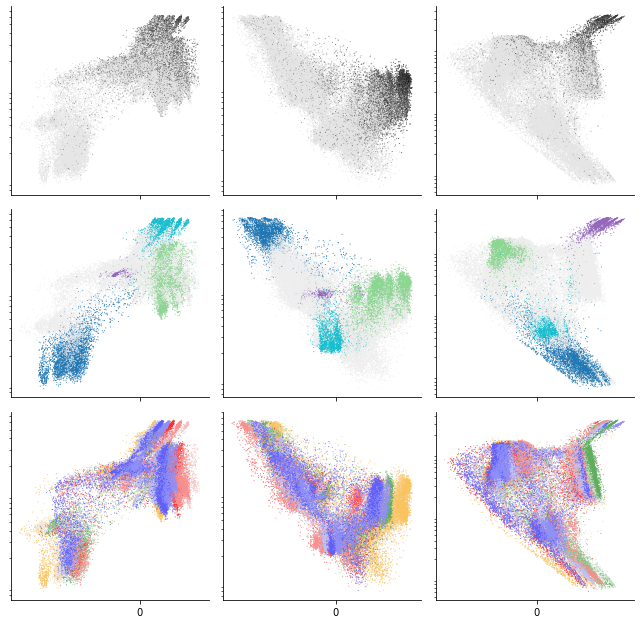

In [169]:
fig, ax = plt.subplots(3,3,figsize=(9,9), sharex = 'col')
entanglement_panel(rna_data, ax[:,0], 'MGAT5', cell_type = 'Naive CD20+ B')
entanglement_panel(rna_data, ax[:,1], 'CCL5', cell_type = 'CD8+ T')
entanglement_panel(rna_data, ax[:,2], 'TCF7L2', cell_type = 'CD16+ Mono')
for _ax in ax[0,:]:
    _ax.set(title = None)
    
plt.savefig('figure1/marginal_panels/v2_entangled_genes.png', 
            bbox_inches = 'tight', dpi = 300)

In [33]:
!realpath figure1/marginal_panels/v2_disentangled_genes.png

/liulab/alynch/projects/multiomics/DisentanglerReproduction/figure1/marginal_panels/v2_disentangled_genes.png


In [34]:
!mkdir -p figure1/marginal_panels/

fig, ax = plt.subplots(3,1,figsize=(3,9))
entanglement_panel(rna_data, ax, 'MAML2')
plt.savefig('figure1/marginal_panels/entangled_MAML2.png')

In [159]:
mira_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA + '2')

mira_model.predict(rna_data)
mira_model.get_batch_effect(rna_data)
mira_model.impute(rna_data)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: batch_effect
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed


/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/plots/base.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  palette_obj = lambda i : np.array(palette)[i]
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/plots/base.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array([class_colors[c_class] for c_class in c])
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/plots/base.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

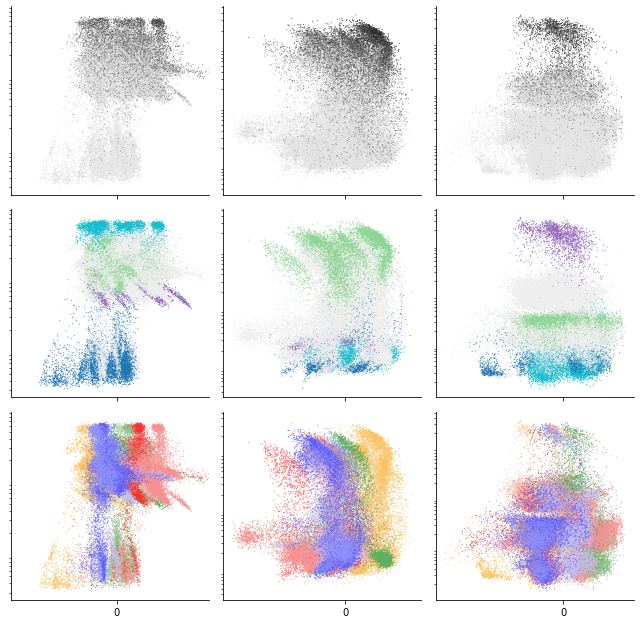

In [160]:
fig, ax = plt.subplots(3,3,figsize=(9,9), sharex = 'col')
entanglement_panel(rna_data, ax[:,0], 'MGAT5', cell_type = 'Naive CD20+ B')
entanglement_panel(rna_data, ax[:,1], 'CCL5', cell_type = 'CD8+ T')
entanglement_panel(rna_data, ax[:,2], 'TCF7L2', cell_type = 'CD16+ Mono')

ax[0,0].set(xlim = (-0.75,0.65))
for _ax in ax[0,:]:
    _ax.set(title = None)
plt.savefig('figure1/marginal_panels/v2_disentangled_genes.png', 
            bbox_inches = 'tight', dpi = 300)

fig, ax = plt.subplots(3,3,figsize=(9,9), sharex = 'col')
entanglement_panel(rna_data, ax[:,0], 'ID2')
entanglement_panel(rna_data, ax[:,1], 'IGLL1')
entanglement_panel(rna_data, ax[:,2], 'CCL5')
plt.savefig('figure1/marginal_panels/disentangled_genes.png', 
            bbox_inches = 'tight', dpi = 300)

In [40]:
from sklearn.preprocessing import minmax_scale

def compare_imputation_plot(g1, g2,
                           g1_palette, g2_palette):

    fig, ax = plt.subplots(2,1,figsize=(3.5,6), sharex=True,
                          sharey=True)
    sns.scatterplot(
        ax = ax[0],
        y = rna_data.obs_vector(g1, layer = 'imputed'), 
        x = rna_data.obs_vector(g2, layer = 'imputed'),
        hue = rna_data.obs_vector('cell_type'),
        palette=list(dt.bonemarrow.colors.CELL_PALETTE.values()), 
        legend=False,
        hue_order = list(dt.bonemarrow.colors.CELL_PALETTE.keys()), 
        s = 1,
    )


    sns.scatterplot(
        ax = ax[1],
        x = rna_data.obs_vector(g2, layer = 'imputed'), 
        y = rna_data.obs_vector(g1, layer = 'imputed'),
        hue = rna_data.obs_vector(g1),
        palette= sns.color_palette(g1_palette, as_cmap=True),
        legend = False,
        s = 1,
    )

    sns.scatterplot(
        ax = ax[1],
        x = rna_data.obs_vector(g2, layer = 'imputed'), 
        y = rna_data.obs_vector(g1, layer = 'imputed'),
        hue = rna_data.obs_vector(g2),
        alpha = minmax_scale(rna_data.obs_vector(g2)),
        palette= sns.color_palette(g2_palette, as_cmap=True),
        legend = False,
        s = 1,
    )

    ax[1].set(yscale = 'log', xscale = 'log', xticks = [], yticks = [])
    sns.despine()
    plt.tight_layout()
    
    return ax
    
    #plt.savefig('figure1/MME_vs_MS4A1_imputation.png')

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


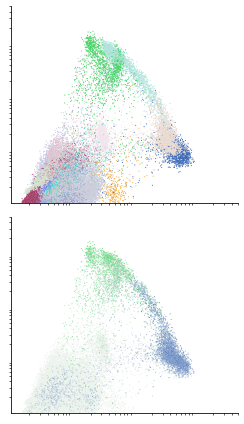

In [41]:
compare_imputation_plot('MME','MS4A1', 
                        'light:' + dt.bonemarrow.colors.CELL_PALETTE['Lymph prog'],
                        'light:' + dt.bonemarrow.colors.CELL_PALETTE['B1 B'])[0]\
    .set(xlim = (1e-5, 5e-2),ylim = (1e-5, 5e-2))

plt.savefig('figure1/MME_vs_MS4A1_imputation.png',
           bbox_inches = 'tight', dpi = 300)

In [7]:
rna_data.obs.cell_type.cat.categories

Index(['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive',
       'CD14+ Mono', 'CD16+ Mono', 'Erythroblast', 'G/M prog', 'HSC',
       'ID2-hi myeloid prog', 'ILC', 'Lymph prog', 'MK/E prog', 'NK',
       'Naive CD20+ B', 'Normoblast', 'Plasma cell', 'Proerythroblast',
       'Transitional B', 'cDC2', 'pDC'],
      dtype='object')

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


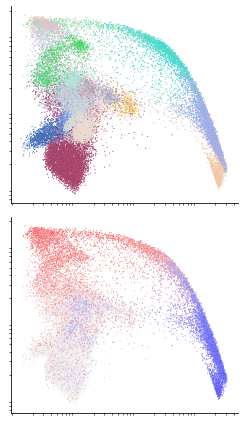

In [9]:
compare_imputation_plot('CDK6','SLC4A1', 
                        'light:' + 'red',# dt.bonemarrow.colors.CELL_PALETTE['MK/E prog'],
                        'light:' + 'blue'#dt.bonemarrow.colors.CELL_PALETTE['Erythroblast'],
                       )
plt.savefig('figure1/CDK6_vs_SLC4A1_imputation.png',
           bbox_inches = 'tight', dpi = 300)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


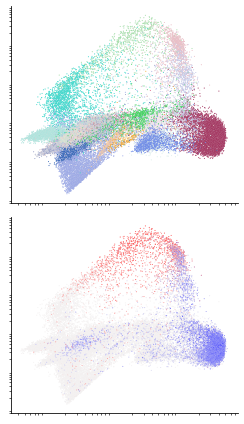

In [10]:
compare_imputation_plot('ZNF385D','CSF3R', 
                        'light:' + 'red',#dt.bonemarrow.colors.CELL_PALETTE['MK/E prog'],
                        'light:' + 'blue'#dt.bonemarrow.colors.CELL_PALETTE['G/M prog'],
                       )
plt.savefig('figure1/ZNF385D_vs_CSF3R_imputation.png',
           bbox_inches = 'tight', dpi = 300)

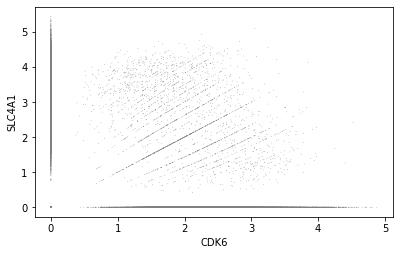

In [12]:
sc.pl.scatter(rna_data,
    x = 'CDK6',
    y = 'SLC4A1'
)